孫世嶸 D10515004

a. 共計有多少Twitter參與這類關鍵字議題討論？

In [4]:
import pyes
import elasticsearch

es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)
bq = pyes.query.BoolQuery() 

# tq = pyes.query.TermQuery(field="text", value="vulnerability")

tq = pyes.filters.TermsFilter(field="text", values=["cybercrime","cve","apt"]) 
ESR = pyes.ESRange(field="created_at", from_value="Thu Jan 01 00:00:00 +0800 2015", to_value="Thu Dec 20 23:59:59 +0800 2015", 
                   include_lower=True ,include_upper=False)
rq = pyes.query.RangeQuery(qrange=ESR)

bq.add_must(tq)
bq.add_must(rq)

Tweetsresult = conn.search(query=bq , indices='twitter2' , doc_types='tweet') 

tweet_id_set=set()
for i in range(0,len(Tweetsresult)):
    if 'id' in Tweetsresult[i]["user"]:
        tweet_id_set.add(Tweetsresult[i]["user"]['id'])
len(tweet_id_set)
# print json.dumps(Tweetsresult[0],indent=2)

77

b. 共計有多少Tweets?

In [3]:
len(Tweetsresult)

2451

c.每個月參與的Twitter數量長條圖

In [5]:
import pyes
import json


tagg2 = pyes.aggs.TermsAgg('name', field= 'uid') 
DHAgg2 = pyes.aggs.DateHistogramAgg('1month' ,field='created_at', interval='1M', sub_aggs=[]) 
DHAgg2.sub_aggs.append(tagg2) 

qsearch2 = pyes.Search(bq)  
qsearch2.agg.add(DHAgg2)

rs2 = conn.search(query=qsearch2 ,indices='twitter2' ,type="tweet" )
allTwitter=[]

# print json.dumps(rs2.aggs,indent=2) 
for user in rs2.aggs['1month']['buckets']:
    user['key_as_string']=user['key_as_string'][26:30]+user['key_as_string'][4:7]
    tempjson = {}
    tempjson['abbr'] = user['key_as_string'] 
    tempjson['times'] = len(user['name']['buckets'])
    allTwitter.append(tempjson)    
# print json.dumps(allTwitter,indent=2)
# df = df_from_json(allTwitter)
# df

In [6]:
from bokeh.charts import Bar, output_file, show
from bokeh.charts.attributes import cat, color
from bokeh.charts.operations import blend
from bokeh.charts.utils import df_from_json
from bokeh.io import output_notebook

# utilize utility to make it easy to get json/dict data converted to a dataframe
df = df_from_json(allTwitter)

bar = Bar(df,
          values=blend('times', name='medals', labels_name='medal'),
          label=cat(columns='abbr', sort=False),
          stack=cat(columns='medal', sort=False),
          color=color(columns='medal', palette=['black'],
                      sort=False),
          legend='top_right',
          title="長條圖")

# output_notebook()
output_file("Twitter_bar.html", title="stacked_bar.py example")

show(bar)

d. 每個月參Tweets數量長條圖

In [4]:
import pyes
import json

tagg = pyes.aggs.TermsAgg('name', field= 'text', sub_aggs=[]) 
DHAgg = pyes.aggs.DateHistogramAgg('1month' ,field='created_at', interval='1M') 
tagg.sub_aggs.append(DHAgg) 

qsearch = pyes.Search(bq)  
qsearch.agg.add(tagg)

rs = conn.search(query=qsearch ,indices='twitter2' ,type="tweet" )

allTweets=[]

for user in rs.aggs['name']['buckets']:      
    if (user['key'].upper()=="apt".upper() or user['key'].upper()=="cybercrime".upper() or user['key'].upper()=="cve".upper()) :
         for month in user['1month']['buckets']:
             month['key_as_string']=month['key_as_string'][26:30]+month['key_as_string'][4:7]
            
for user in rs.aggs['name']['buckets']:      
    if (user['key'].upper()=="apt".upper() or user['key'].upper()=="cybercrime".upper() or user['key'].upper()=="cve".upper()) :
      for month in user['1month']['buckets']: 
        tempjson = {}
        tempjson[user['key']] = month['doc_count']
        tempjson['abbr'] = month['key_as_string']
        allTweets.append(tempjson)    
        
#              print month['key_as_string']+ user['key']
#              print month['doc_count']
# print json.dumps(allTweets,indent=2) 

df = df_from_json(allTweets)

bar = Bar(df,
          values=blend('apt', 'cve', 'cybercrime', name='medals', labels_name='medal'),
          label=cat(columns='abbr', sort=False),
          stack=cat(columns='medal', sort=False),
          color=color(columns='medal', palette=['SaddleBrown', 'Silver', 'Goldenrod'],
                      sort=False),
          legend='top_right',
          title="長條圖")


output_file("stacked_bar.html", title="stacked_bar.py example")
# output_notebook()
show(bar)


INFO:bokeh.core.state:Session output file 'stacked_bar.html' already exists, will be overwritten.


e. 其中有URL與無URL的Tweets的比例圓餅圖

In [8]:
from bokeh.charts import Donut
URLcount=0
NOURLcount=0
allURL=[]
for i in range(0,len(Tweetsresult)):
    if  Tweetsresult[i]['entities']['urls'] != []:
        URLcount=URLcount+1
    else:
        NOURLcount=NOURLcount+1
# print NOURLcount
# print URLcount
# print json.dumps(Tweetsresult[0]['entities']['urls'],indent=2)
tempjson = {}
tempjson['abbr'] = 'URL'
tempjson['times'] = URLcount
allURL.append(tempjson)  
tempjson = {}
tempjson['abbr'] = 'NO_URL'
tempjson['times'] = NOURLcount
allURL.append(tempjson)  
import pandas as pd

# utilize utility to make it easy to get json/dict data converted to a dataframe
df = df_from_json(allURL)

# filter by countries with at least one medal and sort by total medals
# df = df[df['total'] > 8]
# df = df.sort("total", ascending=False)
df = pd.melt(df, id_vars=['abbr'],
             value_vars=['times'],
             value_name='medal_count', var_name='medal')

# original example
d = Donut(df, label=['abbr'], values='medal_count',
          text_font_size='8pt', hover_text='medal_count')

output_file("donut.html", title="donut.py example")

show(d)

INFO:bokeh.core.state:Session output file 'donut.html' already exists, will be overwritten.


f.請依照每個月繪製各Twitter所提到CVE的箱型圖

In [34]:
import pyes
import json

import elasticsearch

es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)
bq2 = pyes.query.BoolQuery() 

# tq = pyes.query.TermQuery(field="text", value="vulnerability")

tq = pyes.filters.TermsFilter(field="text", values=["cve"]) 
ESR = pyes.ESRange(field="created_at", from_value="Thu Jan 01 00:00:00 +0800 2015", to_value="Thu Dec 20 23:59:59 +0800 2015", 
                   include_lower=True ,include_upper=False)
rq = pyes.query.RangeQuery(qrange=ESR)

bq2.add_must(tq)
bq2.add_must(rq)


tagg2 = pyes.aggs.TermsAgg('name', field= 'uid') 
DHAgg2 = pyes.aggs.DateHistogramAgg('1month' ,field='created_at', interval='1M', sub_aggs=[]) 
DHAgg2.sub_aggs.append(tagg2) 
allTwitterPost=[]
cats=[]
qsearch2 = pyes.Search(bq2)  
qsearch2.agg.add(DHAgg2)

rs2 = conn.search(query=qsearch2 ,indices='twitter2' ,type="tweet" )
# print json.dumps(rs2.aggs,indent=2)
for user in rs2.aggs['1month']['buckets']:    
    for post_count in user['name']['buckets']: 
        tempjson = {}
        tempjson['group'] = user['key_as_string'][4:7] 
        tempjson['score'] = post_count['doc_count'] 
        allTwitterPost.append(tempjson)  
        cats.append(str(user['key_as_string'][4:7]))
# print json.dumps(allTwitterPost,indent=2)
from bokeh.charts import BoxPlot, output_file, show
df = pd.DataFrame(allTwitterPost)
# origin = the source of the data that makes up the autompg dataset
title = "MPG by Cylinders and Data Source, Colored by Cylinders"

# color by one dimension and label by two dimensions
# coloring by one of the columns visually groups them together
box_plot = BoxPlot(df, label='group', values='score',
                   color='group', title=title)

output_file("boxplot_single.html", title="boxplot_single.py example")
# output_notebook()
show(box_plot)

INFO:bokeh.core.state:Session output file 'boxplot_single.html' already exists, will be overwritten.


g. 能否分析資安弱點分析指標帳號？如何分析？
   A:分析每篇文章的 favorite_count數與retweet_count數
   給予不同的權重
   favorite +1分
   retweet  +3分
   最後總分數大於自行設定的目標2000分數，即可以成為指標帳號。

In [81]:
import pyes
import json

tagg1 = pyes.aggs.TermsAgg('name', field= 'uid', sub_aggs=[]) 
tagg2 = pyes.aggs.SumAgg('favorite_count' ,field='favorite_count')
tagg3 = pyes.aggs.SumAgg('retweet_count' ,field='retweet_count')

qsearch2 = pyes.Search(bq)
tagg1.sub_aggs.append(tagg2) 
tagg1.sub_aggs.append(tagg3) 
qsearch2.agg.add(tagg1)

rs2 = conn.search(query=qsearch2 ,indices='twitter2' ,type="tweet" )
someone=[]
Uidlist20=[]

# print json.dumps(rs2.aggs,indent=2) 

for user in rs2.aggs['name']['buckets']:
    socre=user['retweet_count']['value']*3+ user['favorite_count']['value']
    if socre >= 2000 :
        tempjson = {}
        tempjson['socre'] = socre
        tempjson['uid'] = user['key']       
        someone.append(tempjson)    
    if socre >= 270 :
        Uidlist20.append(str(user['key']))
df = df_from_json(someone) 
df

,socre,uid
0,5544.0,405658492
1,2610.0,14277681
2,9902.0,18983429
3,3339.0,8917142


3.請選擇20個以上感興趣的Twitter帳號，定義三類分析帳號標籤，並
分析Twitter所討論的Tweet內容，萃取關鍵字為屬性，透過決策術
演算法取得分類規則，請呈現決策術並以Heatmap對於決策樹的參
數進行分析。
依照Twitter關鍵字出現次數
"cybercrime","cve","apt"
分為三類資安界rookie(新手)、veteran(老鳥)、master(大師)

In [107]:
texttagg = pyes.aggs.TermsAgg('uid', field= 'uid', sub_aggs=[]) 
uidagg = pyes.aggs.TermsAgg('text' ,field='text') 
texttagg.sub_aggs.append(uidagg) 

qsearch = pyes.Search(bq)  
qsearch.agg.add(texttagg)

rs = conn.search(query=qsearch ,indices='twitter2' ,type="tweet" )

allTweets=[]

for user in rs.aggs['uid']['buckets']: 
    if any(str(user['key']) in s for s in Uidlist20):
      tempjson = {}
      for KEYtext in user['text']['buckets']:         
            if (KEYtext['key']=="apt" or KEYtext['key']=="cybercrime" or KEYtext['key']=="cve"):               
                tempjson[KEYtext['key']] = KEYtext['doc_count']
                allTweets.append(tempjson)    
# 將計算結果自行製作.csv檔，給予次數分類

In [121]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

iris_data_clean = pd.read_csv('homwork.csv')
# iris_data_clean.head()
# We're using all four measurements as inputs
# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists

# We can extract the data in this format from pandas like this:
all_inputs = iris_data_clean[['apt', 'cybercrime','cve']].values

# Similarly, we can extract the classes
all_classes = iris_data_clean['class'].values

decision_tree_classifier = DecisionTreeClassifier()


parameter_grid = {'max_depth': [1, 2, 3],
                  'max_features': [1, 2, 3]}

cross_validation = StratifiedKFold(all_classes, n_folds=3)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.714285714286
Best parameters: {'max_features': 2, 'max_depth': 3}


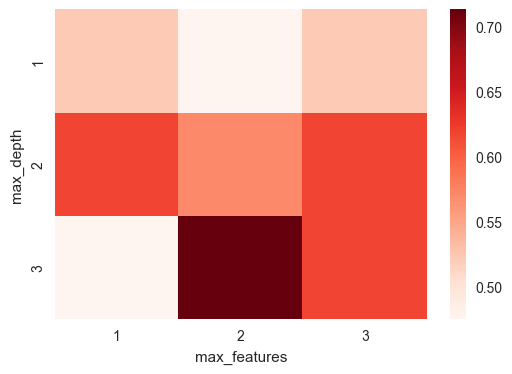

In [122]:
grid_visualization = []

for grid_pair in grid_search.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (3,3)
sb.heatmap(grid_visualization, cmap='Reds')

plt.xticks(np.arange(3) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(3) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')